<h1 style='text-align: center;'> Facial Emotion Detector </h1>

## Importing Libraries

In [1]:
from IPython import display

In [2]:
!pip install utils livelossplot
display.clear_output()

In [4]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from livelossplot.inputs.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
from IPython.display import SVG, Image

import utils

2023-07-30 08:54:25.668725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Dataset

In [5]:
for expression in os.listdir("dataset/train/"):
    print(str(len(os.listdir("dataset/train/" + expression))) + " " + expression + " images")

7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


## Setting up image data generators for training and validation using Keras

In [6]:
# Configuration
img_size = 48
batch_size = 64

# Define a function to create a data generator
def create_data_generator(directory, batch_size, is_training):
    datagen = ImageDataGenerator(horizontal_flip=is_training)
    shuffle = is_training  # Shuffle data only during training
    color_mode = "grayscale"  # Convert images to grayscale
    class_mode = 'categorical'
    
    return datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        color_mode=color_mode,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle
    )

# Paths to the train and test folders
train_folder_path = "dataset/train/"
test_folder_path = "dataset/test/"

# Create data generators for training and validation
train_generator = create_data_generator(train_folder_path, batch_size, is_training=True)
validation_generator = create_data_generator(test_folder_path, batch_size, is_training=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Create Convolutional Neural Network (CNN) Model using Keras¶

In [10]:
# Importing necessary libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from keras.optimizers import Adam

# Initializing the CNN
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output for Fully Connected Layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output Layer
model.add(Dense(7, activation='softmax'))

# Compiling the model
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_9 (Batc  (None, 24, 24, 128)     

## Training and Evaluating Model

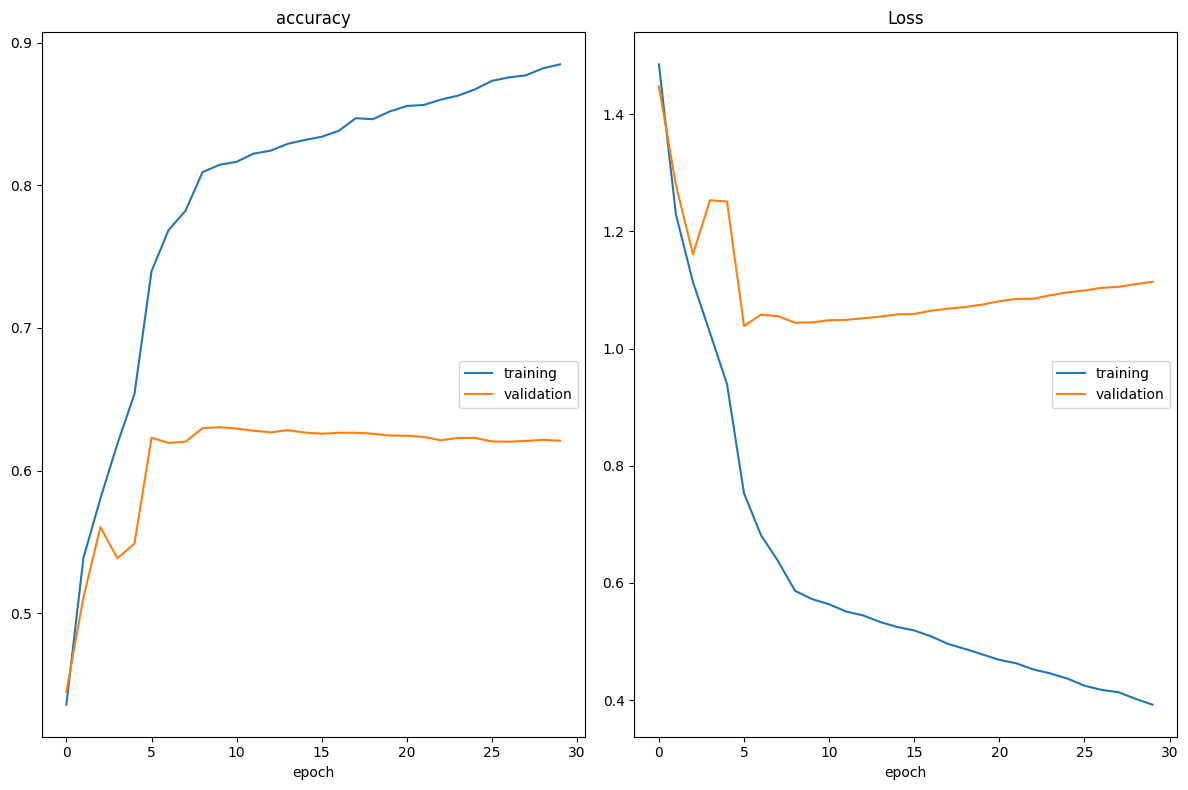

accuracy
	training         	 (min:    0.436, max:    0.885, cur:    0.885)
	validation       	 (min:    0.445, max:    0.630, cur:    0.621)
Loss
	training         	 (min:    0.392, max:    1.485, cur:    0.392)
	validation       	 (min:    1.038, max:    1.448, cur:    1.114)

Epoch 30: saving model to models/emotion_model_small.h5
448/448 [==============================] - 184s 411ms/step - loss: 0.3920 - accuracy: 0.8847 - val_loss: 1.1140 - val_accuracy: 0.6210 - lr: 1.0000e-05
CPU times: user 11h 51min 56s, sys: 1h 17min 50s, total: 13h 9min 46s
Wall time: 1h 48min 53s


In [11]:
%%time

epochs = 30
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("models/emotion_model_small.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

## Represent Model as JSON String

In [13]:
model_json = model.to_json()
with open("models/emotion_model_small.json", "w") as json_file:
    json_file.write(model_json)